In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sqlalchemy import create_engine
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
    f_regression,
    mutual_info_regression,
)
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [3]:
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "lifeexpectancy"
table_name = "lifeexpectancy"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

df = pd.read_sql_query("select * from lifeexpectancy", con=engine)

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

<IPython.core.display.Javascript object>

In [4]:
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


<IPython.core.display.Javascript object>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

<IPython.core.display.Javascript object>

In [6]:
# remove leading and trailing whitespaces in column names
df.columns = [x.strip() for x in df.columns]

<IPython.core.display.Javascript object>

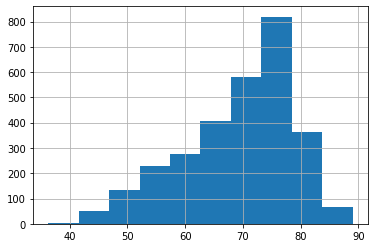

<IPython.core.display.Javascript object>

In [7]:
df["Life expectancy"].hist()

In [8]:
df.isna().mean().sort_values(ascending=False)

Population                         0.221920
Hepatitis B                        0.188223
GDP                                0.152485
Total expenditure                  0.076923
Alcohol                            0.066031
Income composition of resources    0.056841
Schooling                          0.055480
BMI                                0.011572
thinness  1-19 years               0.011572
thinness 5-9 years                 0.011572
Diphtheria                         0.006467
Polio                              0.006467
Adult Mortality                    0.003404
Life expectancy                    0.003404
under-five deaths                  0.000000
HIV/AIDS                           0.000000
Measles                            0.000000
percentage expenditure             0.000000
infant deaths                      0.000000
Status                             0.000000
Year                               0.000000
Country                            0.000000
dtype: float64

<IPython.core.display.Javascript object>

In [9]:
pd.crosstab(df["Population"].isna(), df["Country"])

Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
Population,,,,,,,,,,,,,,,,,,,,,
False,16,16,16,16,0,16,16,16,16,16,...,0,0,16,16,16,0,0,0,16,16
True,0,0,0,0,16,0,0,0,0,0,...,16,16,0,0,0,16,16,16,0,0


<IPython.core.display.Javascript object>

It seems pretty all or nothing for the missing population values. Interpolation definitely doesn't seem correct. Probably best to find the least intrusive central tendency imputation possible.

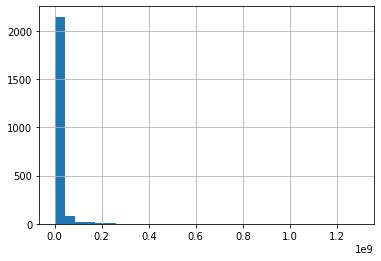

<IPython.core.display.Javascript object>

In [10]:
df["Population"].hist(bins=30)

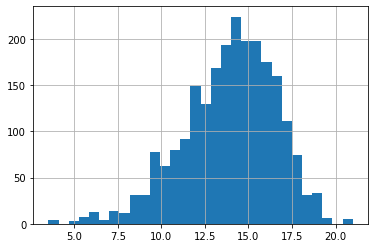

<IPython.core.display.Javascript object>

In [11]:
np.log(df["Population"]).hist(bins=30)

In [12]:
df.sort_values(by="Population", ascending=True).head(5)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
1615,Maldives,2003,Developing,72.7,112.0,0,1.75,491.497891,98.0,75,...,98.0,5.90,98.0,0.1,3432.247841,34.0,14.6,14.7,0.601,11.8
1609,Maldives,2009,Developing,76.3,75.0,0,1.59,100.503021,98.0,6,...,98.0,9.22,98.0,0.1,597.165900,36.0,14.1,14.2,0.651,11.8
1604,Maldives,2014,Developing,78.2,62.0,0,0.01,2051.748615,99.0,0,...,99.0,13.73,99.0,0.1,7716.241500,41.0,13.6,13.7,0.693,12.7
986,Georgia,2008,Developing,73.9,128.0,1,7.17,151.762567,89.0,56,...,9.0,8.99,92.0,0.1,3174.949100,43.0,2.6,2.8,0.735,13.1
1160,Hungary,2010,Developed,74.5,156.0,0,10.78,19.220240,NaN,0,...,99.0,7.85,99.0,0.1,1325.533790,123.0,1.8,1.8,0.817,15.3


<IPython.core.display.Javascript object>

In [13]:
mean_pop = df["Population"].mean()
median_pop = df["Population"].median()
mode_pop = list(df["Population"].value_counts().index)[0]

centrals = [mean_pop, median_pop, mode_pop]

<IPython.core.display.Javascript object>

12753375.120052498


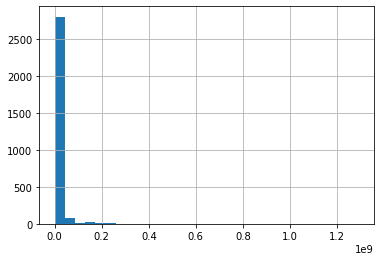

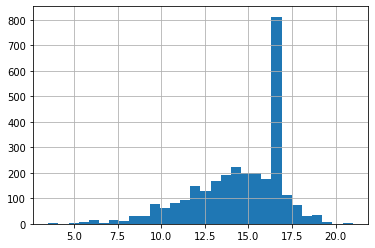

1386542.0


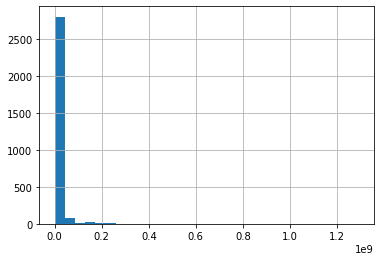

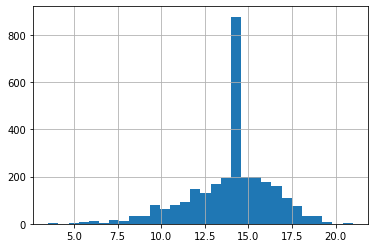

444.0


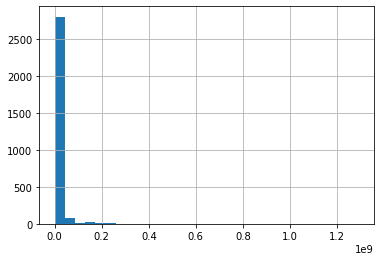

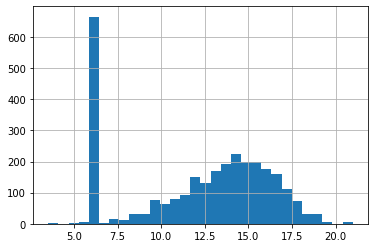

<IPython.core.display.Javascript object>

In [14]:
for c in centrals:
    print(c)
    df["Population"].fillna(value=c).hist(bins=30)
    plt.show()
    np.log(df["Population"].fillna(value=c)).hist(bins=30)
    plt.show()

# median seems to have the smallest impact on distribution when log transformed

In [15]:
mode_pop

444.0

<IPython.core.display.Javascript object>

In [16]:
df["Population"] = df["Population"].fillna(value=median_pop)


<IPython.core.display.Javascript object>

In [17]:
df.isna().mean().sort_values(ascending=False)

Hepatitis B                        0.188223
GDP                                0.152485
Total expenditure                  0.076923
Alcohol                            0.066031
Income composition of resources    0.056841
Schooling                          0.055480
BMI                                0.011572
thinness  1-19 years               0.011572
thinness 5-9 years                 0.011572
Diphtheria                         0.006467
Polio                              0.006467
Adult Mortality                    0.003404
Life expectancy                    0.003404
HIV/AIDS                           0.000000
under-five deaths                  0.000000
Population                         0.000000
Measles                            0.000000
percentage expenditure             0.000000
infant deaths                      0.000000
Status                             0.000000
Year                               0.000000
Country                            0.000000
dtype: float64

<IPython.core.display.Javascript object>

In [18]:
pd.crosstab(df["Hepatitis B"].isna(), df["Country"])
# possibly a better candidate for interpolation

Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
Hepatitis B,,,,,,,,,,,,,,,,,,,,,
False,16,16,12,9,15,14,16,15,16,14,...,14,16,16,14,16,16,13,16,11,16
True,0,0,4,7,1,2,0,1,0,2,...,2,0,0,2,0,0,3,0,5,0


<IPython.core.display.Javascript object>

In [19]:
df[["Country", "Hepatitis B"]].groupby(by="Country").describe()
# distributions seem to be vastly different between countries

Hepatitis B                              \
                                         count       mean        std   min   
Country                                                                      
Afghanistan                               16.0  64.562500   1.824600  62.0   
Albania                                   16.0  98.000000   1.154701  96.0   
Algeria                                   12.0  78.000000  32.827372   8.0   
Angola                                     9.0  70.222222   6.016182  61.0   
Antigua and Barbuda                       15.0  98.266667   0.961150  96.0   
...                                        ...        ...        ...   ...   
Venezuela (Bolivarian Republic of)        16.0  66.250000  26.016661   5.0   
Viet Nam                                  13.0  87.538462  12.156037  59.0   
Yemen                                     16.0  55.687500  25.674160   8.0   
Zambia                                    11.0  69.818182  30.635986   8.0   
Zimbabwe                                  16.0  70.562500  26.510297   7.0   

                                                             
                                      25%   50%   75%   max  
Country                                                      
Afghanistan                         63.00  64.0  66.0  68.0  
Albania                             97.75  98.0  99.0  99.0  
Algeria                             82.50  94.5  95.0  95.0  
Angola                              64.00  72.0  75.0  77.0  
Antigua and Barbuda                 98.00  99.0  99.0  99.0  
...                                   ...   ...   ...   ...  
Venezuela (Bolivarian Republic of)  59.75  78.0  82.0  88.0  
Viet Nam                            87.00  94.0  95.0  97.0  
Yemen                               36.25  69.0  76.0  79.0  
Zambia                              78.50  81.0  84.5  94.0  
Zimbabwe                            68.00  74.0  88.0  97.0  

[193 rows x 8 columns]

<IPython.core.display.Javascript object>

In [20]:
# for country in df["Country"].unique():
#     country_df = df[df["Country"] == country]
#     sns.scatterplot("Year", "Hepatitis B", data=country_df)
#     plt.title(country)
#     plt.show()

# most plots show somewhat linear relationships between years. seems like a good candidate
# for interpolation by year and country

<IPython.core.display.Javascript object>

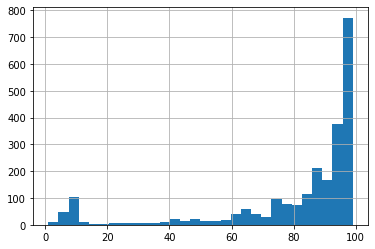

<IPython.core.display.Javascript object>

In [21]:
df["Hepatitis B"].hist(bins=30)

In [22]:
df.loc[:, "Hepatitis B"] = df.loc[:, "Hepatitis B"].interpolate()

<IPython.core.display.Javascript object>

In [23]:
df.isna().mean().sort_values(ascending=False)

GDP                                0.152485
Total expenditure                  0.076923
Alcohol                            0.066031
Income composition of resources    0.056841
Schooling                          0.055480
BMI                                0.011572
thinness  1-19 years               0.011572
thinness 5-9 years                 0.011572
Diphtheria                         0.006467
Polio                              0.006467
Adult Mortality                    0.003404
Life expectancy                    0.003404
HIV/AIDS                           0.000000
Population                         0.000000
under-five deaths                  0.000000
Measles                            0.000000
Hepatitis B                        0.000000
percentage expenditure             0.000000
infant deaths                      0.000000
Status                             0.000000
Year                               0.000000
Country                            0.000000
dtype: float64

<IPython.core.display.Javascript object>

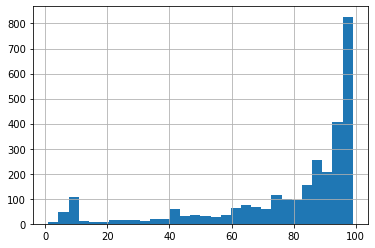

<IPython.core.display.Javascript object>

In [24]:
df["Hepatitis B"].hist(bins=30)  # distribution looks near identical

In [25]:
pd.crosstab(df["GDP"].isna(), df["Country"])  # looks like the same story as population.

Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
GDP,,,,,,,,,,,,,,,,,,,,,
False,16,16,16,16,16,16,16,16,16,16,...,0,0,16,16,16,0,0,0,16,16
True,0,0,0,0,0,0,0,0,0,0,...,16,16,0,0,0,16,16,16,0,0


<IPython.core.display.Javascript object>

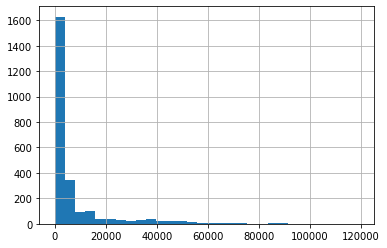

<IPython.core.display.Javascript object>

In [26]:
df["GDP"].hist(bins=30)

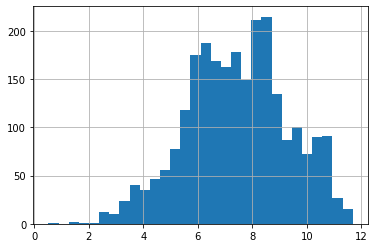

<IPython.core.display.Javascript object>

In [27]:
np.log(df["GDP"]).hist(bins=30)

In [28]:
mean_gdp = df["GDP"].mean()
median_gdp = df["GDP"].median()
mode_gdp = list(df["GDP"].value_counts().index)[0]

centrals = [mean_gdp, median_gdp, mode_gdp]
centrals

[7483.158469138481, 1766.947595, 965.6693779]

<IPython.core.display.Javascript object>

7483.158469138481


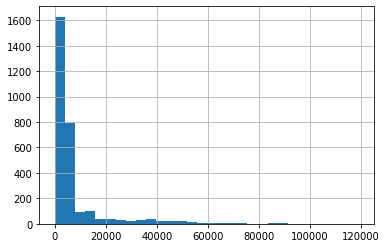

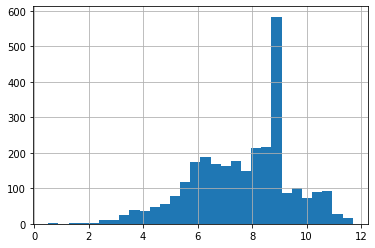

1766.947595


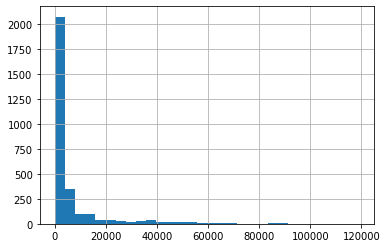

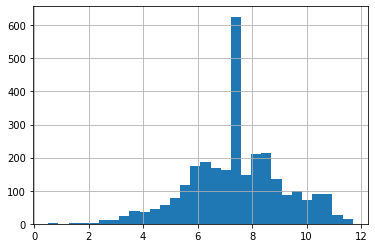

965.6693779


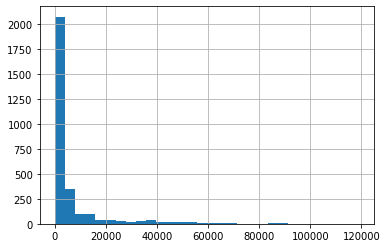

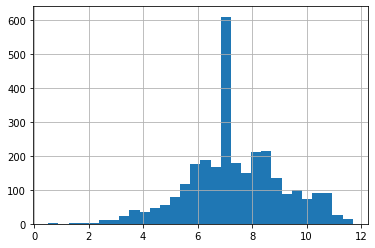

<IPython.core.display.Javascript object>

In [29]:
for c in centrals:
    print(c)
    df["GDP"].fillna(value=c).hist(bins=30)
    plt.show()
    np.log(df["GDP"].fillna(value=c)).hist(bins=30)
    plt.show()

# doesn't seem to make too big of a difference any way.
# just gonna go with median for consistency

In [30]:
df["GDP"] = df["GDP"].fillna(value=median_gdp)

<IPython.core.display.Javascript object>

In [31]:
df.isna().mean().sort_values(ascending=False)

Total expenditure                  0.076923
Alcohol                            0.066031
Income composition of resources    0.056841
Schooling                          0.055480
BMI                                0.011572
thinness 5-9 years                 0.011572
thinness  1-19 years               0.011572
Diphtheria                         0.006467
Polio                              0.006467
Life expectancy                    0.003404
Adult Mortality                    0.003404
GDP                                0.000000
Year                               0.000000
Status                             0.000000
infant deaths                      0.000000
Hepatitis B                        0.000000
percentage expenditure             0.000000
HIV/AIDS                           0.000000
Measles                            0.000000
under-five deaths                  0.000000
Population                         0.000000
Country                            0.000000
dtype: float64

<IPython.core.display.Javascript object>

In [32]:
# Let's see how much data we'll lose at this point if we jsut drop na
rows_all, cols_all = df.shape

rows_filtered, cols_filtered = df.dropna().shape

(rows_all - rows_filtered) / rows_all
# 13 percent is still a lot to lose

0.1300204220558203

<IPython.core.display.Javascript object>

In [33]:
pd.crosstab(df["Total expenditure"].isna(), df["Country"])

Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
Total expenditure,,,,,,,,,,,,,,,,,,,,,
False,16,16,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
True,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


<IPython.core.display.Javascript object>

In [34]:
df[["Country", "Total expenditure"]].groupby(by="Country").describe()
# looks okay to interpolate this as well

Total expenditure                      \
                                               count      mean       std   
Country                                                                    
Afghanistan                                     16.0  8.252500  0.671779   
Albania                                         16.0  5.945625  0.288721   
Algeria                                         15.0  4.604000  1.354984   
Angola                                          15.0  3.919333  0.692753   
Antigua and Barbuda                             15.0  4.791333  0.558798   
...                                              ...       ...       ...   
Venezuela (Bolivarian Republic of)              15.0  4.998667  0.406797   
Viet Nam                                        15.0  5.977333  0.928820   
Yemen                                           15.0  5.005333  0.525423   
Zambia                                          15.0  5.824000  1.345818   
Zimbabwe                                        15.0  6.158667  0.805400   

                                                                      
                                     min     25%   50%     75%   max  
Country                                                               
Afghanistan                         6.73  7.8525  8.19  8.7225  9.42  
Albania                             5.34  5.7700  5.94  6.1550  6.38  
Algeria                             3.24  3.5700  3.84  5.3250  7.21  
Angola                              2.79  3.3800  3.84  4.3900  5.38  
Antigua and Barbuda                 4.13  4.3750  4.53  5.3600  5.65  
...                                  ...     ...   ...     ...   ...  
Venezuela (Bolivarian Republic of)  3.98  4.8250  4.93  5.2450  5.81  
Viet Nam                            4.70  5.2750  5.90  6.6500  7.70  
Yemen                               4.14  4.7000  5.00  5.3600  5.78  
Zambia                              4.26  4.8000  4.99  7.0450  8.18  
Zimbabwe                            4.47  5.7650  6.44  6.6100  7.13  

[193 rows x 8 columns]

<IPython.core.display.Javascript object>

In [35]:
df.loc[:, "Total expenditure"] = df.loc[:, "Total expenditure"].interpolate()

<IPython.core.display.Javascript object>

In [36]:
df.isna().mean().sort_values(ascending=False)

Alcohol                            0.066031
Income composition of resources    0.056841
Schooling                          0.055480
BMI                                0.011572
thinness 5-9 years                 0.011572
thinness  1-19 years               0.011572
Diphtheria                         0.006467
Polio                              0.006467
Life expectancy                    0.003404
Adult Mortality                    0.003404
Population                         0.000000
Year                               0.000000
Status                             0.000000
infant deaths                      0.000000
Hepatitis B                        0.000000
percentage expenditure             0.000000
GDP                                0.000000
Measles                            0.000000
under-five deaths                  0.000000
Total expenditure                  0.000000
HIV/AIDS                           0.000000
Country                            0.000000
dtype: float64

<IPython.core.display.Javascript object>

In [37]:
# Let's see how much data we'll lose at this point if we jsut drop na
rows_all, cols_all = df.shape

rows_filtered, cols_filtered = df.dropna().shape

(rows_all - rows_filtered) / rows_all
# 13 percent is still a lot to lose

0.1279782164737917

<IPython.core.display.Javascript object>

In [38]:
pd.crosstab(df["Alcohol"].isna(), df["Country"])

Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
Alcohol,,,,,,,,,,,,,,,,,,,,,
False,16,16,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
True,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


<IPython.core.display.Javascript object>

In [39]:
df.loc[:, "Alcohol"] = df.loc[:, "Alcohol"].interpolate()

<IPython.core.display.Javascript object>

In [40]:
df.isna().mean().sort_values(ascending=False)

Income composition of resources    0.056841
Schooling                          0.055480
thinness  1-19 years               0.011572
BMI                                0.011572
thinness 5-9 years                 0.011572
Diphtheria                         0.006467
Polio                              0.006467
Life expectancy                    0.003404
Adult Mortality                    0.003404
Population                         0.000000
Alcohol                            0.000000
Year                               0.000000
Status                             0.000000
infant deaths                      0.000000
Hepatitis B                        0.000000
percentage expenditure             0.000000
GDP                                0.000000
Measles                            0.000000
under-five deaths                  0.000000
Total expenditure                  0.000000
HIV/AIDS                           0.000000
Country                            0.000000
dtype: float64

<IPython.core.display.Javascript object>

In [41]:
# Let's see how much data we'll lose at this point if we jsut drop na
rows_all, cols_all = df.shape

rows_filtered, cols_filtered = df.dropna().shape

(rows_all - rows_filtered) / rows_all
# 13 percent is still a lot to lose

0.07147719537100068

<IPython.core.display.Javascript object>

In [42]:
pd.crosstab(df["Income composition of resources"].isna(), df["Country"])

Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
Income composition of resources,,,,,,,,,,,,,,,,,,,,,
False,16,16,16,16,16,16,16,16,16,16,...,0,0,16,16,16,16,16,16,16,16
True,0,0,0,0,0,0,0,0,0,0,...,16,16,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [43]:
# median imputation looks better here.

<IPython.core.display.Javascript object>

In [44]:
inc_median = df["Income composition of resources"].median()
df["Income composition of resources"] = df["Income composition of resources"].fillna(
    value=inc_median
)

<IPython.core.display.Javascript object>

In [45]:
df.isna().mean().sort_values(ascending=False)

Schooling                          0.055480
thinness  1-19 years               0.011572
BMI                                0.011572
thinness 5-9 years                 0.011572
Diphtheria                         0.006467
Polio                              0.006467
Life expectancy                    0.003404
Adult Mortality                    0.003404
percentage expenditure             0.000000
Year                               0.000000
Status                             0.000000
infant deaths                      0.000000
Alcohol                            0.000000
Measles                            0.000000
Hepatitis B                        0.000000
Population                         0.000000
Income composition of resources    0.000000
under-five deaths                  0.000000
Total expenditure                  0.000000
HIV/AIDS                           0.000000
GDP                                0.000000
Country                            0.000000
dtype: float64

<IPython.core.display.Javascript object>

In [46]:
# Let's see how much data we'll lose at this point if we jsut drop na
rows_all, cols_all = df.shape
rows_filtered, cols_filtered = df.dropna().shape
(rows_all - rows_filtered) / rows_all

0.07147719537100068

<IPython.core.display.Javascript object>

In [47]:
pd.crosstab(df["Schooling"].isna(), df["Country"])
# similar all or nothing

Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
Schooling,,,,,,,,,,,,,,,,,,,,,
False,16,16,16,16,16,16,16,16,16,16,...,0,0,16,16,16,16,16,16,16,16
True,0,0,0,0,0,0,0,0,0,0,...,16,16,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [48]:
school_median = df["Schooling"].median()
df["Schooling"] = df["Schooling"].fillna(value=school_median)

<IPython.core.display.Javascript object>

In [49]:
df.isna().mean().sort_values(ascending=False)

BMI                                0.011572
thinness 5-9 years                 0.011572
thinness  1-19 years               0.011572
Diphtheria                         0.006467
Polio                              0.006467
Life expectancy                    0.003404
Adult Mortality                    0.003404
Hepatitis B                        0.000000
Year                               0.000000
Status                             0.000000
infant deaths                      0.000000
Alcohol                            0.000000
percentage expenditure             0.000000
Schooling                          0.000000
Measles                            0.000000
Income composition of resources    0.000000
under-five deaths                  0.000000
Total expenditure                  0.000000
HIV/AIDS                           0.000000
GDP                                0.000000
Population                         0.000000
Country                            0.000000
dtype: float64

<IPython.core.display.Javascript object>

In [50]:
# Let's see how much data we'll lose at this point if we jsut drop na
rows_all, cols_all = df.shape

rows_filtered, cols_filtered = df.dropna().shape

(rows_all - rows_filtered) / rows_all

0.01701837985023826

<IPython.core.display.Javascript object>

At this point, we're only losing 1% of data if we drop the rest of nans which I feel pretty comfortable with

In [51]:
final_df = df.dropna()

<IPython.core.display.Javascript object>

In [52]:
final_df.isna().mean().sort_values(ascending=False)

Schooling                          0.0
Income composition of resources    0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
BMI                                0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
HIV/AIDS                           0.0
GDP                                0.0
Population                         0.0
thinness  1-19 years               0.0
thinness 5-9 years                 0.0
Country                            0.0
dtype: float64

<IPython.core.display.Javascript object>

In [53]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2888 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2888 non-null   object 
 1   Year                             2888 non-null   int64  
 2   Status                           2888 non-null   object 
 3   Life expectancy                  2888 non-null   float64
 4   Adult Mortality                  2888 non-null   float64
 5   infant deaths                    2888 non-null   int64  
 6   Alcohol                          2888 non-null   float64
 7   percentage expenditure           2888 non-null   float64
 8   Hepatitis B                      2888 non-null   float64
 9   Measles                          2888 non-null   int64  
 10  BMI                              2888 non-null   float64
 11  under-five deaths                2888 non-null   int64  
 12  Polio               

<IPython.core.display.Javascript object>

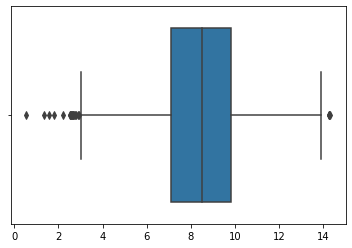

<IPython.core.display.Javascript object>

In [54]:
boxcox, _ = stats.boxcox(final_df["GDP"])
sns.boxplot(boxcox)

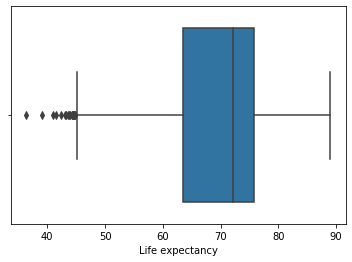

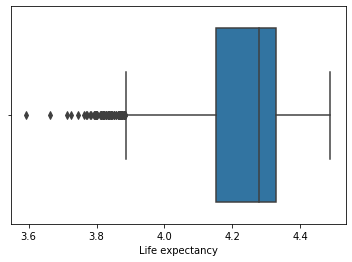

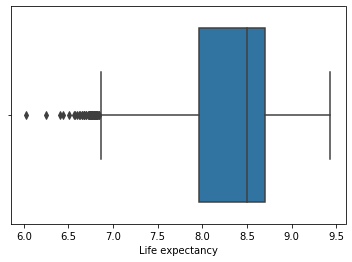

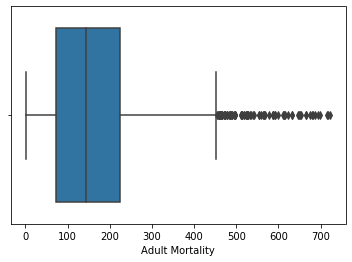

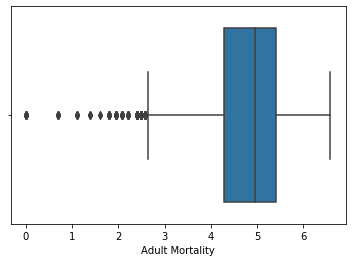

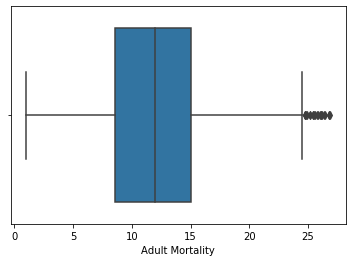

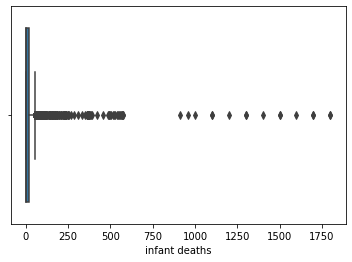

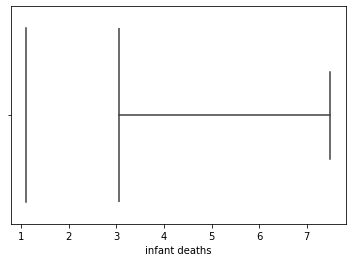

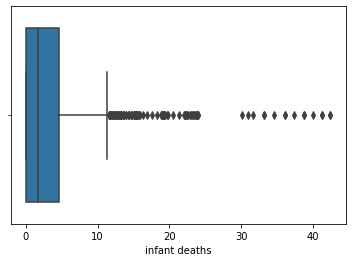

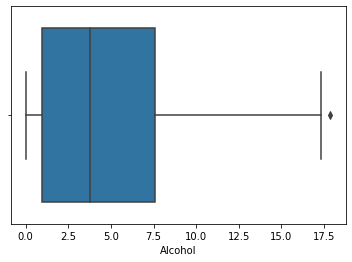

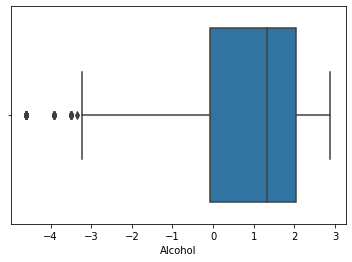

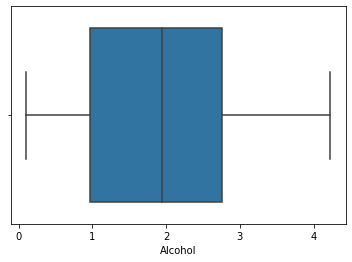

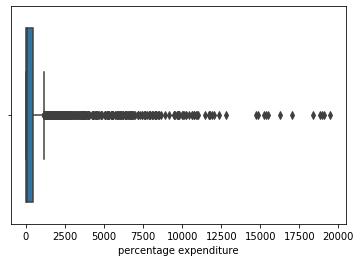

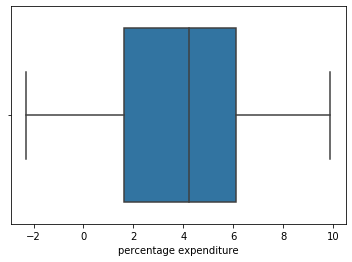

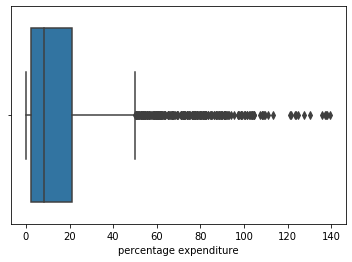

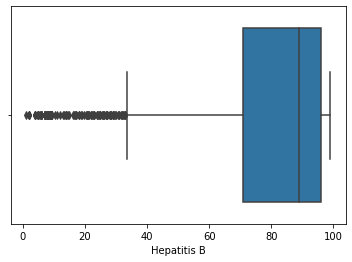

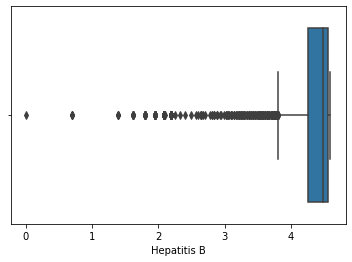

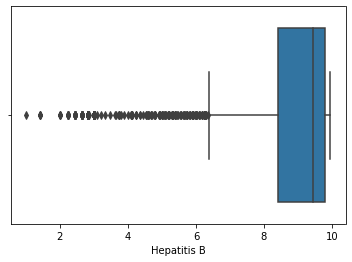

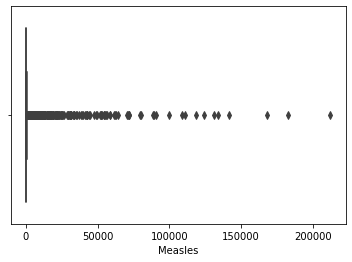

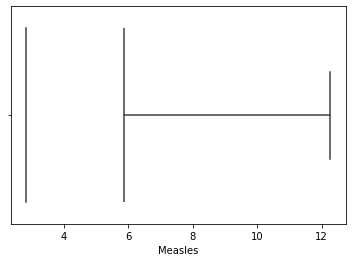

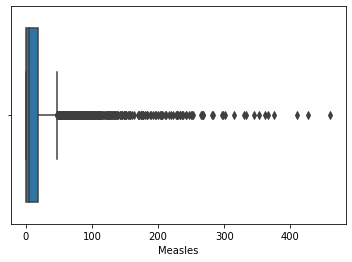

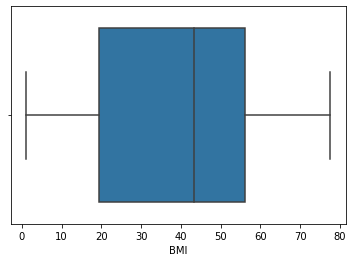

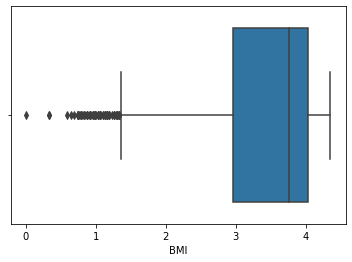

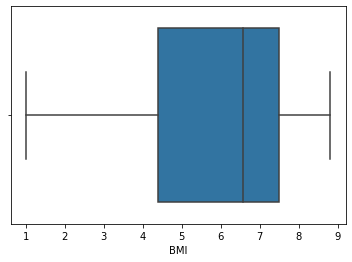

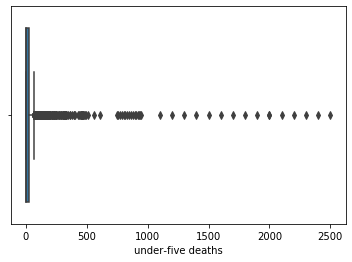

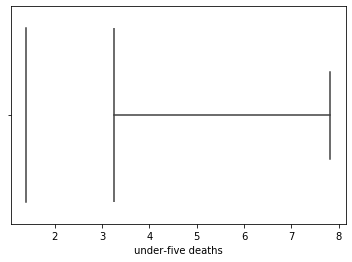

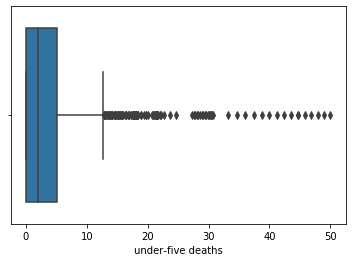

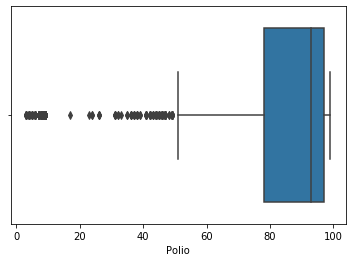

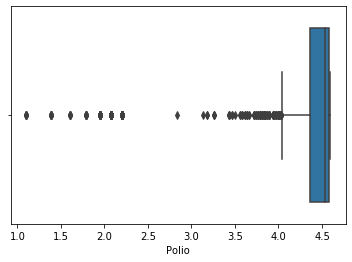

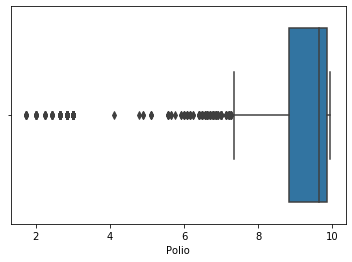

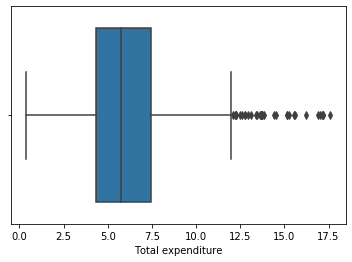

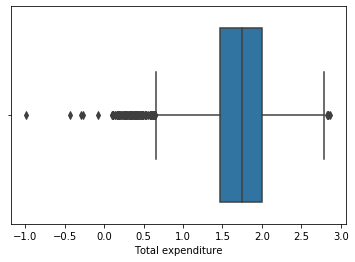

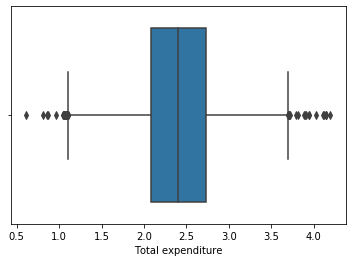

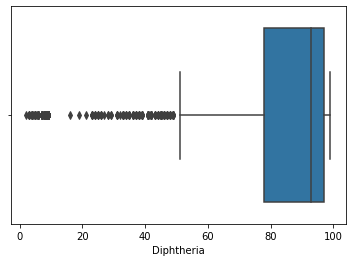

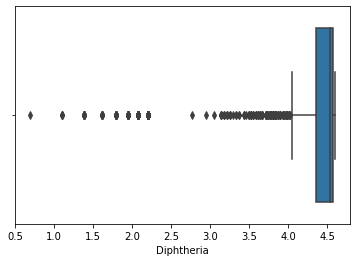

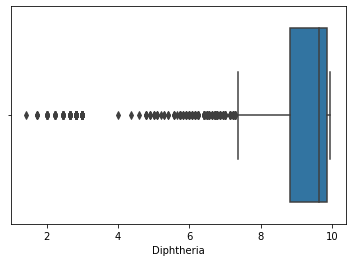

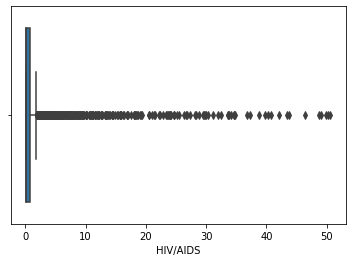

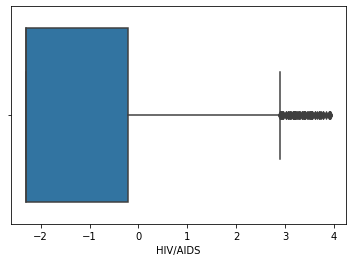

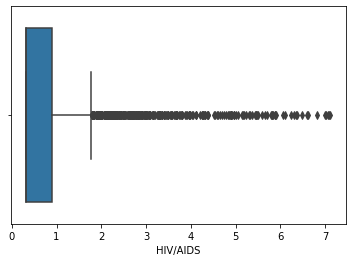

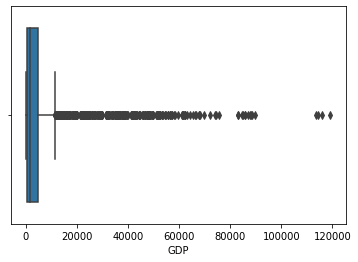

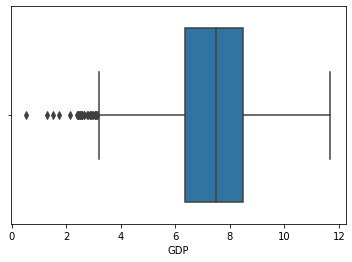

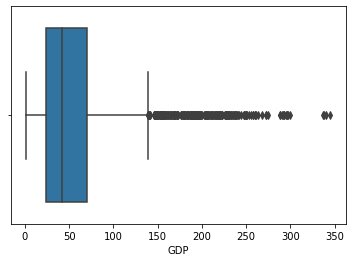

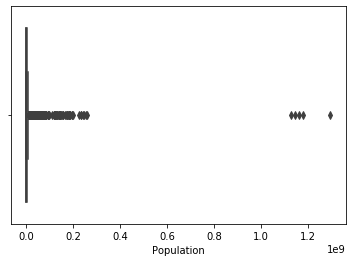

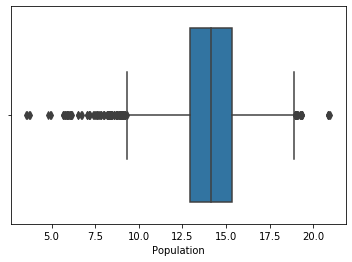

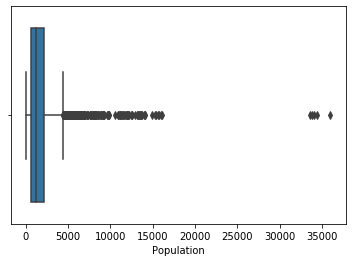

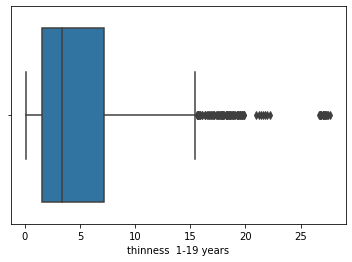

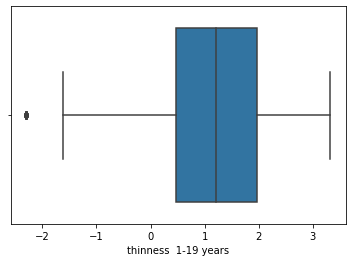

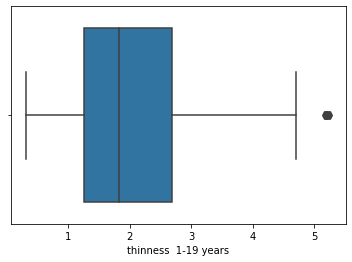

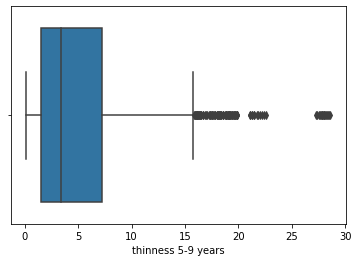

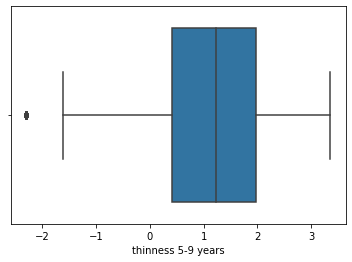

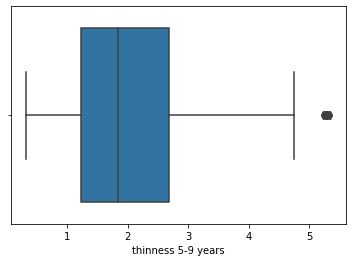

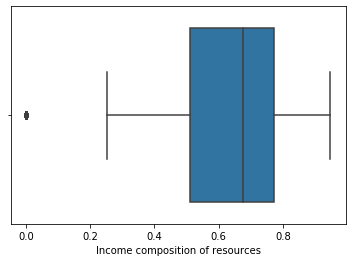

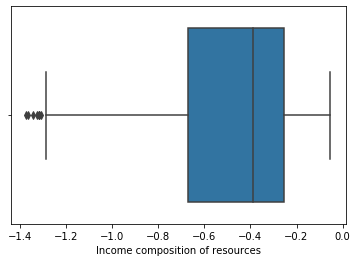

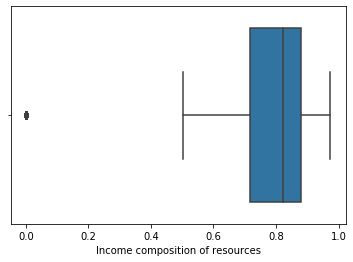

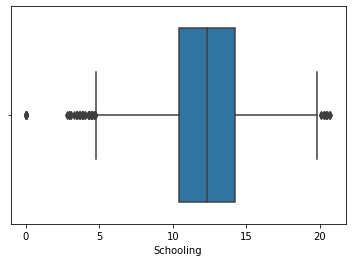

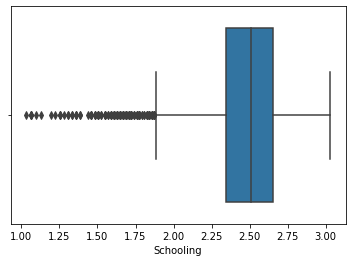

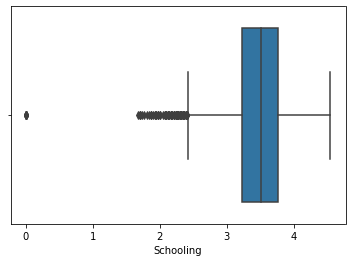

<IPython.core.display.Javascript object>

In [55]:
for col in final_df.columns[3:]:
    sns.boxplot(final_df[col])
    plt.show()

    sns.boxplot(np.log(final_df[col]))
    plt.show()

    sns.boxplot(np.sqrt(final_df[col]))
    plt.show()

#     boxcox, _ = stats.boxcox(final_df[final_df[col>0]])
#     sns.boxplot(boxcox)
#     plt.title(col)
#     plt.show()

In [56]:
nothing_columns = ["BMI"]
winsorize_columns = [
    "Life expectancy",
    "Alcohol",
    "Income composition of resources",
    "Schooling",
]
log_columns = [
    "percentage expenditure",
    "HIV/AIDS",
    "GDP",
    "Population",
    "thinness  1-19 years",
    "thinness 5-9 years",
]
pow_columns = ["Polio", "Diphtheria", "Hepatitis B"]
sqrt_columns = ["Adult Mortality", "Total expenditure"]
dunn = ["infant deaths", "Measles", "under-five deaths"]

<IPython.core.display.Javascript object>

In [57]:
from scipy.stats.mstats import winsorize

<IPython.core.display.Javascript object>

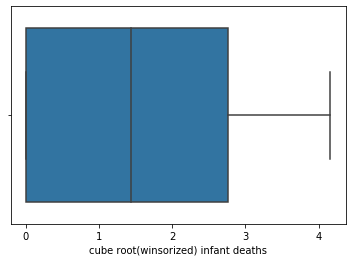

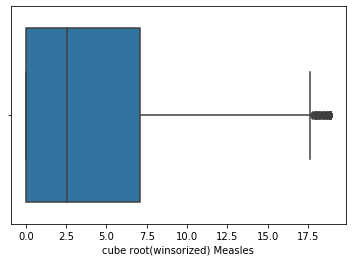

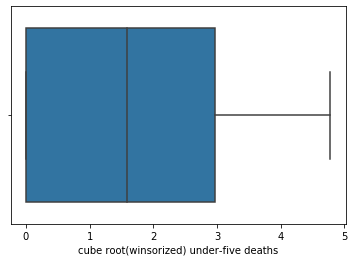

<IPython.core.display.Javascript object>

In [58]:
for col in dunn:
    final_df["cube root(winsorized) " + col] = winsorize(
        pow(final_df[col], 1 / 3), (0.07, 0.07)
    )
    sns.boxplot(final_df["cube root(winsorized) " + col])
    plt.show()

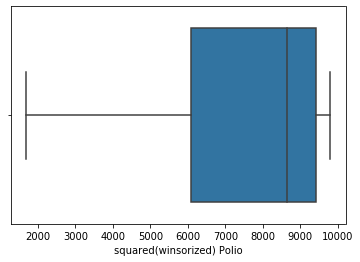

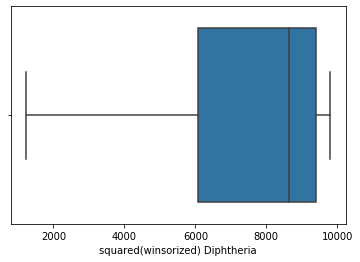

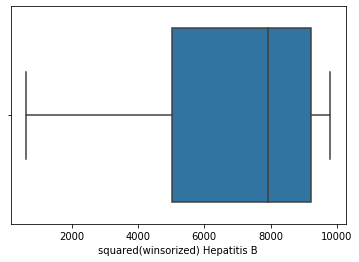

<IPython.core.display.Javascript object>

In [59]:
for col in pow_columns:
    final_df["squared(winsorized) " + col] = winsorize(
        pow(final_df[col], 2), (0.07, 0.07)
    )
    sns.boxplot(final_df["squared(winsorized) " + col])
    plt.show()

In [60]:
# for col in log_columns:
#     boxcox, _ = stats.boxcox(final_df[final_df[col] > 0][col])
#     final_df["boxcox " + col] = pd.Series(boxcox)
#     sns.boxplot(final_df["boxcox " + col])
#     plt.show()

<IPython.core.display.Javascript object>

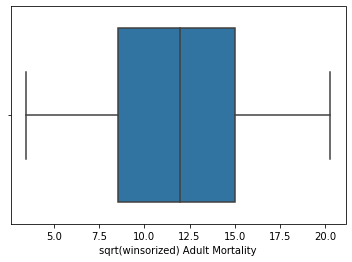

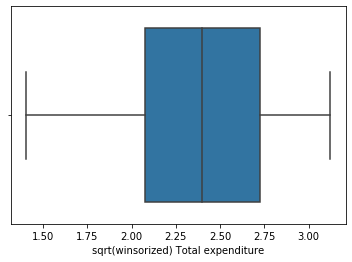

<IPython.core.display.Javascript object>

In [61]:
for col in sqrt_columns:
    final_df["sqrt(winsorized) " + col] = winsorize(
        np.sqrt(final_df[col]), (0.05, 0.05)
    )
    sns.boxplot(final_df["sqrt(winsorized) " + col])
    plt.show()

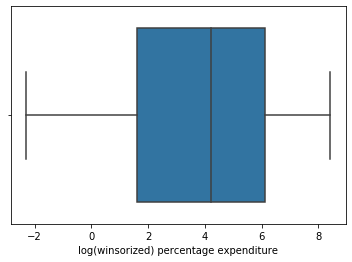

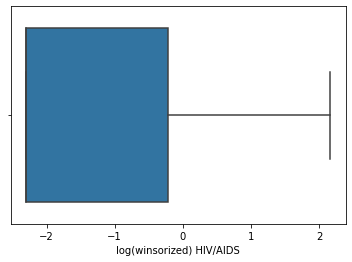

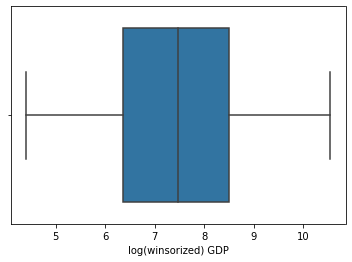

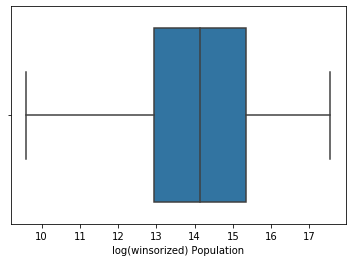

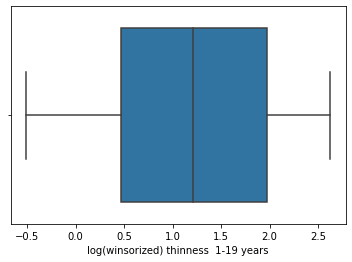

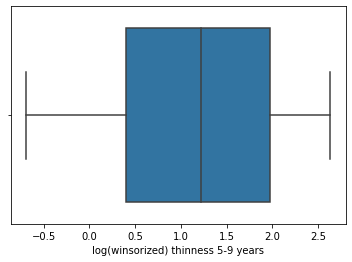

<IPython.core.display.Javascript object>

In [62]:
for col in log_columns:
    final_df["log(winsorized) " + col] = winsorize(np.log(final_df[col]), (0.05, 0.05))
    sns.boxplot(final_df["log(winsorized) " + col])
    plt.show()

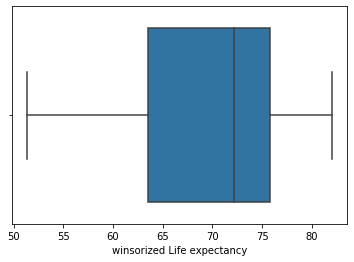

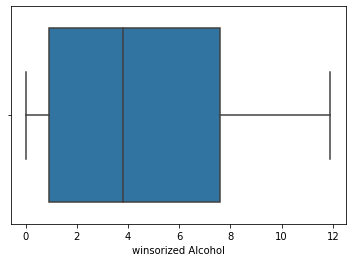

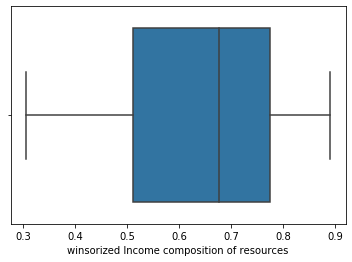

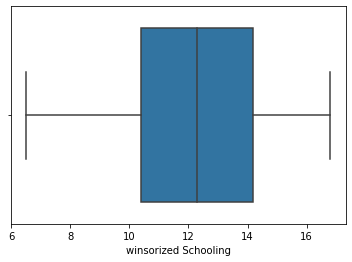

<IPython.core.display.Javascript object>

In [63]:
# winsorizing
for col in winsorize_columns:
    final_df["winsorized " + col] = winsorize(final_df[col], (0.05, 0.05))
    sns.boxplot(final_df["winsorized " + col])
    plt.show()

In [64]:
final_df.head(2)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,log(winsorized) percentage expenditure,log(winsorized) HIV/AIDS,log(winsorized) GDP,log(winsorized) Population,log(winsorized) thinness 1-19 years,log(winsorized) thinness 5-9 years,winsorized Life expectancy,winsorized Alcohol,winsorized Income composition of resources,winsorized Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,4.266611,-2.302585,6.370345,17.334091,2.624669,2.631889,65.0,0.01,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,4.297606,-2.302585,6.417870,12.699494,2.624669,2.631889,59.9,0.01,0.476,10.0


<IPython.core.display.Javascript object>

In [65]:
# 4 Exploring the Data

<IPython.core.display.Javascript object>

In [66]:
final_df.corr().loc["Life expectancy", :].sort_values()

# population doesn't seem useful. neither of the expenditures look useful either
# some of the best tells are HIV/AIDS and Adult Mortality
# schooling and income also seem very important.
# BMI and other weight features seem to play a significant role.

log(winsorized) HIV/AIDS                     -0.813400
Adult Mortality                              -0.693189
cube root(winsorized) under-five deaths      -0.628283
cube root(winsorized) infant deaths          -0.602469
sqrt(winsorized) Adult Mortality             -0.589864
log(winsorized) thinness 5-9 years           -0.576659
log(winsorized) thinness  1-19 years         -0.573293
HIV/AIDS                                     -0.560382
thinness  1-19 years                         -0.476342
thinness 5-9 years                           -0.470744
cube root(winsorized) Measles                -0.332328
under-five deaths                            -0.223172
infant deaths                                -0.197408
Measles                                      -0.160525
log(winsorized) Population                   -0.087147
Population                                   -0.029594
Year                                          0.170772
sqrt(winsorized) Total expenditure            0.206100
Total expe

<IPython.core.display.Javascript object>

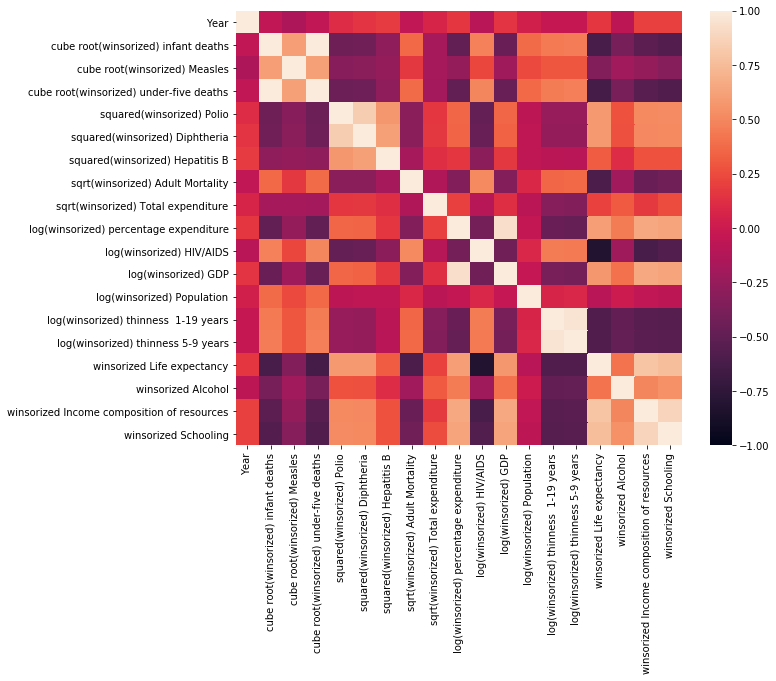

<IPython.core.display.Javascript object>

In [67]:
plt.figure(figsize=(10, 8))
sns.heatmap(final_df.drop(columns=df.columns[2:]).corr(), vmin=-1, vmax=1, annot=False)
plt.show()
# this confirms that population is pretty unhelpful

In [68]:
model_df = pd.get_dummies(final_df, columns=["Country", "Status"], drop_first=True)


<IPython.core.display.Javascript object>

In [69]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

<IPython.core.display.Javascript object>

In [70]:
# model_df = final_df.copy()
model_df = model_df.drop(columns=df.columns[3:])

<IPython.core.display.Javascript object>

In [71]:
model_df.isna().sum()

Year                                       0
cube root(winsorized) infant deaths        0
cube root(winsorized) Measles              0
cube root(winsorized) under-five deaths    0
squared(winsorized) Polio                  0
                                          ..
Country_Viet Nam                           0
Country_Yemen                              0
Country_Zambia                             0
Country_Zimbabwe                           0
Status_Developing                          0
Length: 200, dtype: int64

<IPython.core.display.Javascript object>

In [72]:
X = model_df.drop(
    columns=[
        "winsorized Life expectancy",
        "log(winsorized) percentage expenditure",
    ]  # contains -inf
)
y = model_df["winsorized Life expectancy"]

<IPython.core.display.Javascript object>

In [73]:
selector = SelectKBest(f_regression, k=5)
# selector = SelectKBest(mutual_info_regression, k=5)

# Use `.fit()` method so the selector can 'learn' from our data
selector.fit(X, y)

# Use `.transform()` method so the selector can apply
# what it learned in `.fit()`
k_best = selector.transform(X)

# We can see/rank which features were the best
score_df = pd.DataFrame({"feature": X.columns, "f_score": selector.scores_})
score_df = score_df.sort_values("f_score", ascending=False)
print(score_df.head())

# We can put back into a dataframe to see column names
best_df = pd.DataFrame(k_best, columns=X.columns[selector.get_support()])
best_df.head()

                                       feature      f_score
9                     log(winsorized) HIV/AIDS  5932.300258
15  winsorized Income composition of resources  5003.435514
16                        winsorized Schooling  3895.410231
3      cube root(winsorized) under-five deaths  1989.924936
1          cube root(winsorized) infant deaths  1734.869495


,cube root(winsorized) infant deaths,cube root(winsorized) under-five deaths,log(winsorized) HIV/AIDS,winsorized Income composition of resources,winsorized Schooling
0,3.957892,4.362071,-2.302585,0.479,10.1
1,4.000000,4.414005,-2.302585,0.476,10.0
2,4.041240,4.464745,-2.302585,0.470,9.9
3,4.101566,4.530655,-2.302585,0.463,9.8
4,4.140818,4.594701,-2.302585,0.454,9.5


<IPython.core.display.Javascript object>

In [74]:
# selector = SelectKBest(f_regression, k=5)
selector = SelectKBest(mutual_info_regression, k=5)

# Use `.fit()` method so the selector can 'learn' from our data
selector.fit(X, y)

# Use `.transform()` method so the selector can apply
# what it learned in `.fit()`
k_best = selector.transform(X)

# We can see/rank which features were the best
score_df = pd.DataFrame({"feature": X.columns, "f_score": selector.scores_})
score_df = score_df.sort_values("f_score", ascending=False)
print(score_df.head())

# We can put back into a dataframe to see column names
best_df = pd.DataFrame(k_best, columns=X.columns[selector.get_support()])
best_df.head()

                                       feature   f_score
7             sqrt(winsorized) Adult Mortality  1.197200
15  winsorized Income composition of resources  0.873527
13          log(winsorized) thinness 5-9 years  0.671072
12        log(winsorized) thinness  1-19 years  0.667000
16                        winsorized Schooling  0.650274


,sqrt(winsorized) Adult Mortality,log(winsorized) thinness 1-19 years,log(winsorized) thinness 5-9 years,winsorized Income composition of resources,winsorized Schooling
0,16.217275,2.624669,2.631889,0.479,10.1
1,16.462078,2.624669,2.631889,0.476,10.0
2,16.370706,2.624669,2.631889,0.470,9.9
3,16.492423,2.624669,2.631889,0.463,9.8
4,16.583124,2.624669,2.631889,0.454,9.5


<IPython.core.display.Javascript object>

In [75]:
print("Feature variances before scaling:")
print(X.var().sort_values(ascending=False).head())

scaler = StandardScaler()

# 'learn' from the data
scaler.fit(X)

# apply what the scaler learned
scaled_X = scaler.transform(X)
scaled_df = pd.DataFrame(scaled_X, columns=X.columns)

print("Feature variances after scaling:")
print(scaled_df.var().sort_values(ascending=False).head())

Feature variances before scaling:
squared(winsorized) Hepatitis B     8.596410e+06
squared(winsorized) Diphtheria      6.882970e+06
squared(winsorized) Polio           6.436931e+06
cube root(winsorized) Measles       3.376865e+01
sqrt(winsorized) Adult Mortality    2.181489e+01
dtype: float64
Feature variances after scaling:
Country_Montenegro               1.000346
cube root(winsorized) Measles    1.000346
Year                             1.000346
winsorized Schooling             1.000346
squared(winsorized) Polio        1.000346
dtype: float64


<IPython.core.display.Javascript object>

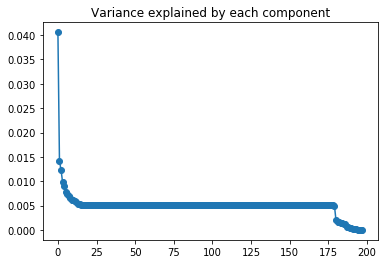

<IPython.core.display.Javascript object>

In [76]:
pca = PCA()

# 'learn' from the data
pca.fit(scaled_X)

# apply what the pca object learned
pca_X = pca.transform(scaled_X)

# What attribute holds the variance explained?
plt.plot(pca.explained_variance_ratio_, marker="o")
plt.title("Variance explained by each component")
plt.show()


In [77]:
pd.concat((model_df, pd.DataFrame(pca_X)), axis="columns").corr()[
    [0, 1, 2, 3, 4, 5]
].style.background_gradient()

<IPython.core.display.Javascript object>